# Некоторые примеры парсинга с BeautifulSoup и Pandas

*Алла Тамбовцева*

Импортируем библиотеки и функцию `BeautifulSoup` (понадобятся для разных примеров ниже):

* `requests` для отправки запроса и получения кода HTML веб-страницы;
* `bs4` для поиска тэгов в коде HTML;
* `pandas` для обработки полученной информации и приведения ее к табличному виду.

In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup

### Сюжет 1. Парсинг таблиц: BeautifulSoup vs Pandas

Для игрушечного примера создадим строку с кодом HTML для маленькой таблицы с двумя строками и тремя столбцами:

In [2]:
# tr – table row (строка), 
# th – table header (ячейка с заголовком столбца), 
# td - table data (ячейка с данными)


table = """
<table>
  <tr><th>id</th><th>name</th><th>mark</th></tr>
  <tr><td>1</td><td>Anna</td><td>7</td></tr>
  <tr><td>3</td><td>Ben</td><td>6</td></tr>
</table>
"""

Посмотрим на то, как эта таблица выглядит. Для этого скопируем строку с кодом HTML без кавычек в ячейку Jupyter Notebook и изменим ее тип на *Markdown*, он позволит преобразовать код в таблицу и покажет ее на экране:

<table>
  <tr><th>id</th><th>name</th><th>mark</th></tr>
  <tr><td>1</td><td>Anna</td><td>7</td></tr>
  <tr><td>3</td><td>Ben</td><td>6</td></tr>
</table>

Сконвертируем строку `table` (тип *string*) в объект `BeautifulSoup` для удобства поиска по тэгам:

In [3]:
tab = BeautifulSoup(table)
tab

<html><body><table>
<tr><th>id</th><th>name</th><th>mark</th></tr>
<tr><td>1</td><td>Anna</td><td>7</td></tr>
<tr><td>3</td><td>Ben</td><td>6</td></tr>
</table>
</body></html>

Найдем все ячейки с данными по тэгу `<td>` и извлечем из кода HTML текст:

In [4]:
tds = tab.find_all("td")
values = [v.text for v in tds]
values

['1', 'Anna', '7', '3', 'Ben', '6']

Теперь, чтобы получить полноценную таблицу, нужно разбить список на части (две строки) и преобразовать в датафрейм. Эту задачу можно решать по-разному. Мы преобразуем список в массив и разобьем его на два массива одинаковой длины через функцию `split()` из библиотеки `numpy`:

In [5]:
import numpy as np

In [6]:
pd.DataFrame(np.split(np.array(values), 2)) 

,0,1,2
0,1,Anna,7
1,3,Ben,6


Итак, мы посмотрели, как можно с помощью BeautifulSoup, Numpy и Pandas справиться с парсингом фрагмента HTML-кода, содержащим таблицу. На самом деле, можно было поступить гораздо проще – задействовать специальную функцию `read_html()` из библиотеки `pandas`. Вернемся к строке `table` с кодом HTML (преобразовывать ее в объект BeautifulSoup не нужно) и воспользуемся этой функцией:

In [7]:
# по умолчанию считывает все таблицы и возвращает все таблицы из HTML в виде списка
# здесь одна – извлекаем элемент с индексом 0

pd.read_html(table)[0] 

,id,name,mark
0,1,Anna,7
1,3,Ben,6


Теперь перейдем к более продвинутой задаче. Зайдем на сайт Левада-Центра и найдем на [странице](https://www.levada.ru/indikatory/) с индикаторами одобрения органов власти первую таблицу с данными (под первым графиком, имеет индекс 0):

In [8]:
page = requests.get("https://www.levada.ru/indikatory/")
soup = BeautifulSoup(page.text)
tab0 = soup.find_all("table", {"class" : "datatable"})[0]

Преобразуем объект `tab0` в строку, так как функция `read_html()` умеет работать только с обычными строками или файлами, а не с объектами `BeautifulSoup`, и создаем датафрейм на основе кода HTML, указав, что первая строка таблицы содержит заголовки столбцов (`header`):

In [9]:
df = pd.read_html(str(tab0), header = 0)[0]
df

,08.1999,09.1999,10.1999,11.1999,12.1999,01.2000,02.2000,03.2000,04.2000,05.2000,...,02.2022,03.2022,04.2022,05.2022,06.2022,07.2022,08.2022,09.2022,10.2022,11.2022
0,31,53,65,80,79,84,75,70,77,72,...,71,83,82,83,83,83,83,77,79,79
1,33,27,20,12,13,10,17,21,15,17,...,27,15,17,15,16,15,15,21,19,18
2,37,20,15,8,8,7,8,9,8,11,...,1,2,1,2,1,2,2,2,2,3


Ура! Одной строчкой кода мы получили красивую таблицу вместо «сырого» фрагмента HTML. Давайте транспонируем полученный датафрейм, чтобы получить более привычный вариант таблицы (и удобный для визуализации, если нас интересует динамика процента одобряющий и неодобряющих):

In [10]:
df = df.transpose() 
df

,0,1,2
08.1999,31,33,37
09.1999,53,27,20
10.1999,65,20,15
11.1999,80,12,8
12.1999,79,13,8
...,...,...,...
07.2022,83,15,2
08.2022,83,15,2
09.2022,77,21,2
10.2022,79,19,2


Обработаем этот датафрейм:

* добавим названия столбцов;
* извлечем даты из названией строк (атрибут `index`) и сохраним их в отдельный столбец;
* в качестве названий строк добавим набор целых чисел от 0 до 277;
* переставим столбцы местами – выбирем их в нужном порядке и перезаписываем `df`;

In [11]:
df.columns = ["yes", "no", "no answer"]
df["date"] = df.index
df.index = range(0, 278) 
df = df[["date", "yes", "no", "no answer"]]
df

,date,yes,no,no answer
0,08.1999,31,33,37
1,09.1999,53,27,20
2,10.1999,65,20,15
3,11.1999,80,12,8
4,12.1999,79,13,8
...,...,...,...,...
273,07.2022,83,15,2
274,08.2022,83,15,2
275,09.2022,77,21,2
276,10.2022,79,19,2


Проверим типы столбцов:

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278 entries, 0 to 277
Data columns (total 4 columns):
date         278 non-null object
yes          278 non-null int64
no           278 non-null int64
no answer    278 non-null int64
dtypes: int64(3), object(1)
memory usage: 8.8+ KB


Все отлично, числовые данные сохранены как целые числа, но дату стоит перевести в специальный формат `datetime`, иначе сортировать данные и визуализировать их будет сложно – текст с датами не будет упорядочиваться хронологически. Воспользуемся функцией `to_datetime()` и укажем, в каком формате у нас сохранены даты (про форматы и соответствующие аббревиатуры можно почитать [здесь](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior)):

In [13]:
# format: в каком формате даты в строке
# %m - шаблон для месяцев в числовом виде
# %Y – шаблон для лет в числовом виде (Y - 4 цифры, y – 2 цифры)

df["date"] = pd.to_datetime(df["date"], format = "%m.%Y")

Тип столбца изменился:

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278 entries, 0 to 277
Data columns (total 4 columns):
date         278 non-null datetime64[ns]
yes          278 non-null int64
no           278 non-null int64
no answer    278 non-null int64
dtypes: datetime64[ns](1), int64(3)
memory usage: 8.8 KB


И для определенности к каждой дате (а у нас был только месяц и год) приписалось число – первый день месяца:

In [15]:
df.head()

,date,yes,no,no answer
0,1999-08-01,31,33,37
1,1999-09-01,53,27,20
2,1999-10-01,65,20,15
3,1999-11-01,80,12,8
4,1999-12-01,79,13,8


Проверим, что при визуализации динамики все будет в порядке, хронология не будет нарушена. Построим маленький базовый график с помощью функции `plot()`, без особых настроек, для примера. Импортируем модуль `pyplot`:

In [16]:
from matplotlib import pyplot as plt

Давайте в одной координатной плоскости построим сразу два графика – покажем динамику для процента одобряющих и неодобряющих деятельность Владимира Путина:

/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


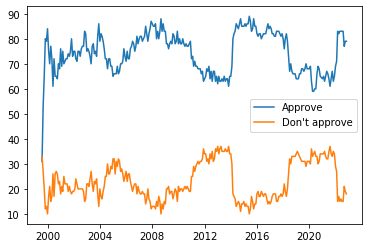

In [17]:
# label – чтобы назвать каждый график и отразить это в легенде

plt.plot(df["date"], df["yes"], label = "Approve")
plt.plot(df["date"], df["no"], label = "Don't approve")
plt.legend() 

Отлично! График готов, похож на аналогичный график на сайте Левада-Центра. Конечно, размер и масштаб у этого графика не очень подходящие, но это всегда можно исправть (см. дополнительные материалы к занятию).

### Сюжет 2. Очень краткое введение в регулярные выражения

Регулярные выражения – выражения, последовательности символов, которые позволяют искать совпадения в тексте. Выражаясь более формально, они помогают найти подстроки определенного вида в строке. Еще о регулярных выражениях можно думать как о шаблонах, в которые мы можем подставлять текст, и этот текст либо соответствует шаблону, либо нет. 

В самом простом случае в качестве регулярного выражения может использоваться обычная строка. Например, чтобы найти в предложении *Кошка сидит под столом.* слово *Кошка*, ничего специального применять не нужно, достаточно воспользоваться оператором `in`. Если нас интересует слово *кошка* в любом регистре, то это уже более интересная задача. Правда, ее все еще можно решить без регулярных выражений, приведя все слова в строке к нижнему регистру. А что, если у нас будет текст подлиннее, и в нем необходимо «обнаружить» *кошку* в разных падежах? И еще производные слова вроде *кошечка*? Тут уже удобнее написать некоторый шаблон, чтобы не создавать длинный список слов с разными формами слова *кошка*. Давайте немного потренируемся (но не на кошках).

Импортируем модуль `re` для работы с регулярными выражениями:

In [18]:
import re

В качестве игрушечного примера возьмем обычную строку со странным текстом (текст невнятный, но отражает эволюцию смеха на пути к сессии):

In [19]:
data0 = "ha haha ha-ha hah heh. hse."

Найдем в этой строке все подстроки, которые соответствуют шаблону `h.h` – вместо точки может быть любой символ (буква, цифра, пробел и прочие знаки). Воспользуемся функцией `findall()`, она возвращает список совпадений:

In [20]:
re.findall("h.h", data0)

['hah', 'hah', 'heh']

Если нужны именно точки, символ `.` нужно экранировать с помощью `\`, в такой записи слэш показывает, что мы ищем именно точку, а не используем ее как специальный символ, принятый в синтаксисе регулярных выражений. Итак, найдем все «слова», начинающиеся с `h`, состоящие из четырех символов, последний из которых – точка:

In [21]:
re.findall("h..\.", data0)

['heh.', 'hse.']

Точка – далеко не единственный специальный символ в регулярных выражениях. Так, символ `+`  показывает, что нас интересуют случаи, когда элемент, стоящий слева от `+`, встречается не менее одного раза. Найдем подстроки, где точно есть буква `h`, а за ней стоит хотя бы одна буква `a`:

In [22]:
# подстроки с h с хотя бы с одной буквой a
re.findall("ha+", data0)

['ha', 'ha', 'ha', 'ha', 'ha', 'ha']

Если мы допускаем, что буквы `a` может не быть совсем, нам понадобится другой символ – символ `*` (ноль и более вхождений элемента, стоящего слева от `*`):

In [23]:
# подстроки, где точно есть h, а буква a встречается или нет
re.findall("ha*", data0)

['ha', 'ha', 'ha', 'ha', 'ha', 'ha', 'h', 'h', 'h', 'h']

А если нас интересуют случаи, когда какой-то символ встречается ноль раз или один раз, то пригодится символ `?`:

In [24]:
# подстроки haha или ha-ha, с дефисом посередине и без него
re.findall("ha-?ha", data0)

['haha', 'ha-ha']

Особую роль в регулярных выражениях играют скобки разного вида. Круглые скобки могут использоваться для объединения символов в группы, а квадратные – для перечисления всех вариантов, которые могут встретиться в некотором месте строки:

In [25]:
# hah или heh с точкой или пробелом на конце
# \s – обозначение пробела (от space)

re.findall("h[ae]h[\.\s]", data0)

['hah ', 'heh.']

В квадратные скобки также можно вписывать последовательности – готовые перечни известных символов:

* `[a-z]`: строчные буквы английского алфавита;
* `[A-Z]`: заглавные буквы английского алфавита;
* `[а-я]`: строчные буквы русского алфавита;
* `[А-Я]`: заглавные буквы русского алфавита;
* `[0-9]`: цифры от 0 до 9.

Проверим, есть ли в нашей строке цифры:

In [26]:
re.findall("[0-9]", data0)  # нет, мы и не ждали

[]

А теперь проверим, есть ли в нашей строке последовательности ровно из трех строчных английских букв. Для этого пригодится еще один вид скобок – фигурные. В фигурных скобках указывают количество символов, которое необходимо найти:

In [27]:
# последовательности ровно из трех английских букв
re.findall("[a-z]{3}", data0)

['hah', 'hah', 'heh', 'hse']

Если мы не знаем точное количество символов, но знаем интервал, его границы тоже можно указать в фигурных скобках через запятую:

In [28]:
# последовательности из 3-4 английских букв
re.findall("[a-z]{3,4}", data0)

['haha', 'hah', 'heh', 'hse']

Границы интервала можно опускать:

In [29]:
# последовательности не менее, чем из 3 английских букв
re.findall("[a-z]{3,}", data0)

['haha', 'hah', 'heh', 'hse']

In [30]:
# последовательности не более, чем из 3 английских букв (пустые тоже есть)
re.findall("[a-z]{,3}", data0)

['ha',
 '',
 'hah',
 'a',
 '',
 'ha',
 '',
 'ha',
 '',
 'hah',
 '',
 'heh',
 '',
 '',
 'hse',
 '',
 '']

Давайте повнимательнее посмотрим на поиск цифр и чисел, может пригодиться, например, для обработки номеров телефонов или адресов. Создадим другую, более вразумительную строку:

In [31]:
data1 = "+7(906)000-11-23 Alla Borisovna" 

Пока просто найдем все цифры:

In [32]:
re.findall("[0-9]", data1)

['7', '9', '0', '6', '0', '0', '0', '1', '1', '2', '3']

Для поиска цифр вместо последовательности часто используют ее сокращенную версию – специальный символ `\d` (от *digits*, экранируется с помощью слэша, чтобы не путать с обычной буквой *d*):

In [33]:
re.findall("\d", data1)

['7', '9', '0', '6', '0', '0', '0', '1', '1', '2', '3']

Цифры нашли, но ведь цифры в строке – далеко не всегда номер телефона, теоретически они могут быть и в адресе (как обычном, так и электронном), и в названии сайта.  Напишем паттерн для поиска именно номера телефона в предположении, что:

* телефон точно начинается с `+7`;
* после `+7` обязательно стоят скобки вокруг первых трех цифр;
* а вот дефисы между группами цифр могут отсутствовать):

In [34]:
# \+7: экранируем +, чтобы не путать со специальным символом +
# (\d{3}\): набор из 3 цифр в скобках
# \d{3}: набор из 3 цифр
# -?: дефис встречается 0 или 1 раз
# \d{2}: набор из 2 цифр

re.findall("\+7\(\d{3}\)\d{3}-?\d{2}-?\d{2}", data1)

['+7(906)000-11-23']

Если допустить, что телефон может начинаться с `8`, а не только с `+7`, выражение будет выглядеть так:

In [35]:
# \+?: + встречается 0 или 1 раз
# после 7 или 8

re.findall("\+?[78]\(\d{3}\)\d{3}-?\d{2}-?\d{2}", data1)

['+7(906)000-11-23']

Проверим на другой строке:

In [36]:
data2 = "+7(906)000-11-23 Alla Borisovna 8(906)111-00-23 Alla Andreevna" 
re.findall("\+?[78]\(\d{3}\)\d{3}-?\d{2}-?\d{2}", data2)

['+7(906)000-11-23', '8(906)111-00-23']

Ну, а если допустить, что «приставки» `+7` или `8` может вообще не быть, то понадобится еще один `?`:

In [37]:
data3 = "+7(906)000-11-23 Alla Borisovna 8(906)111-00-23 Alla Andreevna (999)233-00-21 Alla" 
re.findall("\+?[78]?\(\d{3}\)\d{3}-?\d{2}-?\d{2}", data3)

['+7(906)000-11-23', '8(906)111-00-23', '(999)233-00-21']

Итак, на этом краткое введение в регулярные выражения мы закончим, сейчас увидим, зачем они могут понадобиться при парсинге, даже если мы выгружаем информацию с помощью BeautifulSoup.

### Сюжет 3. Извлечение информации из кода JavaScript внутри HTML

В конце курса по Python в магистратуре у нас было [домашнее задание](https://github.com/allatambov/PyMs2022/blob/main/pyall-hw05.ipynb) на парсинг страницы фильма «Не покидай...» с сайта www.kino-teatr.ru. Сайт некоммерческий, довольно дружелюбный, позволяет свободно выгружать информацию. Но у него есть одна особенность: число лайков и дизлайков, поставленных актерам пользователями, загружается на страницу динамически, то есть автоматически «подтягивается» с сервера при загрузке страницы в определенный момент времени. На практике это выливается в то, что найти нужную информацию по тэгам просто невозможно, ее нет в основном коде HTML. Как быть? Понять, как выглядит запрос данных, который отправляется на сервер, и выяснить, где хранятся нужные нам данные. Мы рассмотрим несложный случай, когда сайт забирает информацию из строки JSON, которая находится на странице, но внутри кода, написанного на JavaScript. Такое можно встретить на страницах с результатами каких-нибудь игр или на сайтах, посвященных динамике цен или курсу валют (другой вопрос, что не всегда JSON прямо так явно находится в том же файле, где и код HTML).

Так как ранее мы обсуждали довольно базовый парсинг, в домашнем задании не требовалось собирать число лайков и дизлайков, эти значения были даны в виде готовых массивов. Обновим задачу – теперь нам нужно собрать имена актеров и их id, а затем «подтянуть» к этой информации число голосов за и против. 

Начало работы стандартное – загружаем код HTML страницы по ссылке и преобразуем его в объект BeautifulSoup:

In [38]:
page = requests.get("https://www.kino-teatr.ru/kino/movie/sov/4319/titr/")
soup = BeautifulSoup(page.text)

Ищем имена актеров – находим блоки с тэгами `<div>` с классом `film_name` и вытаскиваем из них «чистый» текст:

In [39]:
names_raw = soup.find_all("div", {"class" : "film_name"}) 
names = [name.text for name in names_raw]

print(names[0:10]) # первые 10 для примера

['Лидия Федосеева-Шукшина', 'Вячеслав Невинный', 'Игорь Красавин', 'Варвара Владимирова', 'Светлана Селезнёва', 'Регина Разума', 'Альберт Филозов', 'Артём Тынкасов', 'Елена Антонова', 'Владимир Ставицкий']


Теперь ищем id, они нам понадобятся для совмещения с информацией по числу голосов за и против:

In [40]:
divs = soup.find_all("div", {"class" : "actor_film_descript"}) 
print(divs[0:2])

[<div class="actor_film_descript" id="role_16801">
<div class="film_name"><a href="/kino/acter/w/sov/4484/bio/" itemprop="url" title="Лидия Федосеева-Шукшина"><strong itemprop="name">Лидия Федосеева-Шукшина</strong></a></div>
<div class="film_role">Королева Флора — <span class="film_main_role">главная роль</span></div>
<div class="film_role_descript">жена короля Теодора</div>
<div class="film_rating"><span id="role_rating_16801"></span></div>
</div>, <div class="actor_film_descript" id="role_16800">
<div class="film_name"><a href="/kino/acter/m/sov/3035/bio/" itemprop="url" title="Вячеслав Невинный"><strong itemprop="name">Вячеслав Невинный</strong></a></div>
<div class="film_role">Король Теодор — <span class="film_main_role">главная роль</span></div>
<div class="film_rating"><span id="role_rating_16800"></span></div>
</div>]


Как можно заметить, числовых id здесь нет, но это легко исправить – забрать значения атрибута `id` через метод `.get()` (вспоминаем о сходстве объектов BeautifulSoup и словарей), разбить их по символу `_` и забрать часть после `_` с индексом 1:

In [41]:
ids = [i.get("id").split("_")[1] for i in divs]
print(ids[0:10])

['16801', '16800', '16803', '16802', '89473', '124124', '16804', '132138', '56008', '132139']


Теперь воспользуемся тем, что функция `DataFrame()` из библиотеки pandas умеет превращать в датафрейм не только списки списков или словари, но и списки кортежей. Объединим элементы в список попарно через функцию `zip()` и сконвертируем перечень пар-кортежей в датафрейм:

In [42]:
# напоминание: как выглядят элементы в zip()

list(zip(ids, names))[0:10]

[('16801', 'Лидия Федосеева-Шукшина'),
 ('16800', 'Вячеслав Невинный'),
 ('16803', 'Игорь Красавин'),
 ('16802', 'Варвара Владимирова'),
 ('89473', 'Светлана Селезнёва'),
 ('124124', 'Регина Разума'),
 ('16804', 'Альберт Филозов'),
 ('132138', 'Артём Тынкасов'),
 ('56008', 'Елена Антонова'),
 ('132139', 'Владимир Ставицкий')]

In [43]:
main = pd.DataFrame(zip(ids, names))
main.columns = ["id", "name"] 
main

,id,name
0,16801,Лидия Федосеева-Шукшина
1,16800,Вячеслав Невинный
2,16803,Игорь Красавин
3,16802,Варвара Владимирова
4,89473,Светлана Селезнёва
5,124124,Регина Разума
6,16804,Альберт Филозов
7,132138,Артём Тынкасов
8,56008,Елена Антонова
9,132139,Владимир Ставицкий


Теперь переходим к более сложной части – поиску голосов за и против. Просто найти на странице кнопки красного и зеленого цвета и забрать с них текст не получится:

![](НП.jpeg)

Поэтому для этого на нужно найти код JavaScript, где есть записи с числами `plus` и `minus` с привязкой к id актеров. Код JavaScript, если он не вынесен в отдельный файл, заключается в тэги `<script>`. Если мы внимательно изучим исходный код страницы, мы заметим, что нужный нам блок кода имеет атрибут `type` со значением `text/javascript`, и среди таких блоков он находится на 7-ом месте:

In [44]:
# выполняем поиск и извлекаем текст – код JavaScript в виде строки

text = soup.find_all("script", {"type" : "text/javascript"})[6].text 
text

'\r\n<!--\r\n\r\n// Рисуем кнопки в javascript\r\nfunction print_role_rating_buttons(role)\r\n{\r\n    var span = $("#role_rating_"+role.id);\r\n    var site = \'desktop\'\r\n\r\n    if (span) {\r\n        if (site == \'desktop\') {\r\n            span.html("<input type=\'button\' value=\'+ " + role.plus +"\' class=\'acter_vote acter_vote_plus rating_button like\' title=\'Мне понравилась эта актёрская работа\' mark=\'plus\' clicked=\'0\' role_id=\'" + role.id +"\' onClick=\'return sendVote(this)\' mark=\'plus\'> <input type=\'button\' value=\'- " + role.minus + "\' class=\'acter_vote acter_vote_minus rating_button dislike\' title=\'Мне не понравилась эта актёрская работа\' mark=\'minus\' clicked=\'0\' role_id=\'" + role.id +"\' onClick=\'return sendVote(this)\' mark=\'minus\'>")\r\n        } else {\r\n            span.html("<button class=\'acter_vote acter_vote_plus ui-btn ui-btn-inline ui-corner-all ui-btn-text-left ui-btn-icon-left ui-icon-plus\' title=\'Мне понравилась эта актёрская

Блок с кодом довольно большой, в нем содержатся разные функции для отрисовки и обновления информации на кнопках (на них отображаются голоса за и против, на них же можно кликать после авторизации, чтобы записать свой голос). Нам же понадобится часть кода после функции `print_role_rating_buttons ()`, так как именно под ней располагается необходимая информация. Воспользуемся методом `.split()` и разобьем строку на части:

In [45]:
for_votes = text.split("function print_all_role_rating_buttons ()")[1]
print(for_votes)


{
    print_role_rating_buttons({ id:"160325", plus:"52", minus:"1", voted:"" });
print_role_rating_buttons({ id:"1928641", plus:"24", minus:"1", voted:"" });
print_role_rating_buttons({ id:"1966145", plus:"20", minus:"0", voted:"" });
print_role_rating_buttons({ id:"1973000", plus:"20", minus:"0", voted:"" });
print_role_rating_buttons({ id:"1973001", plus:"20", minus:"0", voted:"" });
print_role_rating_buttons({ id:"1973002", plus:"21", minus:"0", voted:"" });
print_role_rating_buttons({ id:"1973003", plus:"22", minus:"0", voted:"" });
print_role_rating_buttons({ id:"1973005", plus:"21", minus:"2", voted:"" });
print_role_rating_buttons({ id:"1973007", plus:"25", minus:"0", voted:"" });
print_role_rating_buttons({ id:"1973008", plus:"19", minus:"0", voted:"" });
print_role_rating_buttons({ id:"1973010", plus:"29", minus:"3", voted:"" });
print_role_rating_buttons({ id:"1973011", plus:"31", minus:"1", voted:"" });
print_role_rating_buttons({ id:"2088754", plus:"26", minus:"1", voted:

Хотя с синтаксисом JavaScript знакомы немногие, не очень сложно догадаться, что означают записи такого вида:

    print_role_rating_buttons({ id:"16800", plus:"140", minus:"4", voted:"" });
    
Такая строка кода активирует функцию `print_role_rating_buttons()` – применяет ее к такому набору данных и наносит на кнопки, соответствующие актеру с id 16800 значения 140 (зеленая кнопка) и 4 (красная кнопка):

![](ВН.jpeg)

*Примечание 1*. Синхронизация не происходит мгновенно, актуальное значение 140 подставляется на кнопку не сразу, там вполне может стоять значение 139, а мы, благодаря значениям из JavaScript, обладаем более актуальной информацией. Это стоит иметь в виду при выгрузке информации, когда мы сверяем полученные результаты и то, что видим на экране.

*Примечание 2*. Значение `voted` в коде выше является непустым, в случае, если пользователь зарегистрирован и оценивал игру актера (по крайней мере, какое-то время после голосования значение в `voted` держится, потом на самой странице отметка о голосовании остается, а в JSON стирается). Сравним скрин и фрагменты кода для такого случая:

![](ВС_ЕА.jpeg)
    
Код:

    print_role_rating_buttons({ id:"56008", plus:"90", minus:"10", voted:"plus" });
    print_role_rating_buttons({ id:"132139", plus:"106", minus:"4", voted:"plus" });


Все фрагменты кода выше – это обычные строки, объекты типа *string*. Поэтому с помощью регулярных выражений мы сможем найти в них записи в фигурных скобках, затем сделать из них словари, а из списка словарей с единообразными ключами собрать датафрейм!

Найдем все подстроки, соответствующие шаблону `\{.+\}`, то есть просто все наборы символов, заключенных в фигурные скобки (скобки экранируем, чтобы не перепутать со специальными скобками в регулярных выражениях):

In [46]:
votes_str = re.findall("\{.+\}", for_votes)
votes_str

['{ id:"160325", plus:"52", minus:"1", voted:"" }',
 '{ id:"1928641", plus:"24", minus:"1", voted:"" }',
 '{ id:"1966145", plus:"20", minus:"0", voted:"" }',
 '{ id:"1973000", plus:"20", minus:"0", voted:"" }',
 '{ id:"1973001", plus:"20", minus:"0", voted:"" }',
 '{ id:"1973002", plus:"21", minus:"0", voted:"" }',
 '{ id:"1973003", plus:"22", minus:"0", voted:"" }',
 '{ id:"1973005", plus:"21", minus:"2", voted:"" }',
 '{ id:"1973007", plus:"25", minus:"0", voted:"" }',
 '{ id:"1973008", plus:"19", minus:"0", voted:"" }',
 '{ id:"1973010", plus:"29", minus:"3", voted:"" }',
 '{ id:"1973011", plus:"31", minus:"1", voted:"" }',
 '{ id:"2088754", plus:"26", minus:"1", voted:"" }',
 '{ id:"16800", plus:"140", minus:"4", voted:"" }',
 '{ id:"16801", plus:"98", minus:"21", voted:"" }',
 '{ id:"16803", plus:"117", minus:"12", voted:"" }',
 '{ id:"16802", plus:"130", minus:"7", voted:"" }',
 '{ id:"16804", plus:"130", minus:"4", voted:"" }',
 '{ id:"56008", plus:"90", minus:"10", voted:"" }',

Выберем один элемент списка и изучим его:

In [47]:
v = votes_str[0]
v

'{ id:"160325", plus:"52", minus:"1", voted:"" }'

На первый взгляд, этот элемент представляет собой полноценный словарь, просто заключенный в кавычки. 
Однако есть проблема: чтобы переделать строку в словарь, нужна строка, соответствующая формату JSON, а здесь не хватает кавычек вокруг ключей. Как эту проблему решить? Найти по какому-то паттерну эти ключи и доклеить вокруг них кавычки с помощью функции `sub()` из модуля `re` для «умной» замены (не обычная замена, так как мы не конкретный набор символов заменяем на другой, а ищем совпадения по некоторому общему шаблону и их изменяем). 

Поиск будет простой – в строке с «неправильным» словарем содержатся либо цифры, либо буквы, либо пробелы с запятыми и знаками препинания, а нам нужны последовательности из одной и более букв:

In [48]:
re.findall("[a-z]+", v)

['id', 'plus', 'minus', 'voted']

Напишем функцию `add_quotes()`, которая принимает на вход строку `x`, доклеивает к ней кавычки и убирает пробелы. Нам нужно преобразовать строку `x` в группу – объект из регулярных выражений – через `+` доклеить кавычки и на всякий случай убрать лишние пробелы:

In [49]:
# x.group(): функция sub() из re для умной замены
# работает не со строками, а с объектом специального типа – группа символов

def add_quotes(x):
    g = '"' + x.group() + '"'
    return g.strip()

Применяем функцию `sub` к одной строке `v` и проверяем:

In [50]:
# аргументы:
# шаблон, по которому ищем, что заменять
# функция, которая выполняет преобразование – доклеивает к результатм поиска кавычки
# строка, по который выполняем поиск

re.sub("[a-z]+", add_quotes, v)

'{ "id":"160325", "plus":"52", "minus":"1", "voted":"" }'

Все работает, применяем ко всем строкам и получаем список валидных json-строк:

In [51]:
votes_new = [re.sub("[a-z]+", add_quotes, v) for v in votes_str]
votes_new

['{ "id":"160325", "plus":"52", "minus":"1", "voted":"" }',
 '{ "id":"1928641", "plus":"24", "minus":"1", "voted":"" }',
 '{ "id":"1966145", "plus":"20", "minus":"0", "voted":"" }',
 '{ "id":"1973000", "plus":"20", "minus":"0", "voted":"" }',
 '{ "id":"1973001", "plus":"20", "minus":"0", "voted":"" }',
 '{ "id":"1973002", "plus":"21", "minus":"0", "voted":"" }',
 '{ "id":"1973003", "plus":"22", "minus":"0", "voted":"" }',
 '{ "id":"1973005", "plus":"21", "minus":"2", "voted":"" }',
 '{ "id":"1973007", "plus":"25", "minus":"0", "voted":"" }',
 '{ "id":"1973008", "plus":"19", "minus":"0", "voted":"" }',
 '{ "id":"1973010", "plus":"29", "minus":"3", "voted":"" }',
 '{ "id":"1973011", "plus":"31", "minus":"1", "voted":"" }',
 '{ "id":"2088754", "plus":"26", "minus":"1", "voted":"" }',
 '{ "id":"16800", "plus":"140", "minus":"4", "voted":"" }',
 '{ "id":"16801", "plus":"98", "minus":"21", "voted":"" }',
 '{ "id":"16803", "plus":"117", "minus":"12", "voted":"" }',
 '{ "id":"16802", "plus":"1

Теперь нам осталось считать эти валидные JSON-строки с помощью Python – то есть превратить их в обычные питоновские словари.  Импортируем модуль `json`:

In [52]:
import json

Проверяем работу функции `loads()` на примере первой строки из полученного списка `votes_new`:

In [53]:
json.loads(votes_new[0])

{'id': '160325', 'plus': '52', 'minus': '1', 'voted': ''}

Напоминание: в модуле `json` есть две похожих функции:

* `load()` загружает данные из файла с расширением `.json`;
* `loads()` – загружает данные из JSON-строки.

Теперь применим эту функцию ко всем строкам в `votes_new` и сразу преобразуем получившийся список словарей в датафрейм:

In [54]:
ratings = pd.DataFrame([json.loads(v) for v in votes_new])
ratings

,id,plus,minus,voted
0,160325,52,1,
1,1928641,24,1,
2,1966145,20,0,
3,1973000,20,0,
4,1973001,20,0,
5,1973002,21,0,
6,1973003,22,0,
7,1973005,21,2,
8,1973007,25,0,
9,1973008,19,0,


Ура! Вся относительно тяжелая работа проделана, осталось вспомнить, что у нас есть датафрейм `main`, в который мы хотели добавить информацию о числе лайков и дизлайков:

In [55]:
main.head()

,id,name
0,16801,Лидия Федосеева-Шукшина
1,16800,Вячеслав Невинный
2,16803,Игорь Красавин
3,16802,Варвара Владимирова
4,89473,Светлана Селезнёва


Объединим два датафрейма, `main` и `ratings` по столбцу с названием `id` с помощью метода `.merge()`. Нам понадобится тип объединения `left`, так как мы не хотим терять информацию по тем актерам, по которым голосования на странице не было, а хотим просто к первому (левому) датафрейму подтянуть информацию из второго (правого). Если такой информации нет, строка из `main` не удалится, просто на соответствующих местах в объединенном датафрейме будут пропуски:

In [56]:
final = main.merge(ratings, on = "id", how = "left")
final 

,id,name,plus,minus,voted
0,16801,Лидия Федосеева-Шукшина,98,21,
1,16800,Вячеслав Невинный,140,4,
2,16803,Игорь Красавин,117,12,
3,16802,Варвара Владимирова,130,7,
4,89473,Светлана Селезнёва,89,20,
5,124124,Регина Разума,107,7,
6,16804,Альберт Филозов,130,4,
7,132138,Артём Тынкасов,121,2,
8,56008,Елена Антонова,90,10,
9,132139,Владимир Ставицкий,106,4,


Отсортируем строки по числу положительных оценок:

In [57]:
final.sort_values("plus")

,id,name,plus,minus,voted
9,132139,Владимир Ставицкий,106,4,
5,124124,Регина Разума,107,7,
10,72744,Анатолий Рудаков,115,3,
2,16803,Игорь Красавин,117,12,
7,132138,Артём Тынкасов,121,2,
3,16802,Варвара Владимирова,130,7,
6,16804,Альберт Филозов,130,4,
1,16800,Вячеслав Невинный,140,4,
30,1973008,Юрий Шульга,19,0,
24,1973000,Валерий Мороз,20,0,


Результат сортировки получился странным: Владимир Ставицкий с числом положительных оценок 105 оказался на первом месте, Регина Разума с числом 106 – на втором, при этом Вячеслав Невинный с самым большим числом «плюсов» расположился на восьмом месте. Логика сортировки не похожа ни на убывание, ни на возрастание. Мистика, не иначе :)

Если серьезно, почему так вышло? Проблема в том, что тип столбцов `plus` и `minus` остался строковым, а строки сортируются посимвольно: сравниваются первые символы, потом вторые, потом третьи... Сортировка по умолчанию идет по возрастанию, поэтому сначала идут строки, начинающиеся с 1, затем – с 2, и так далее, а внутри каждой группы сортировка проходит по второму символу, и если нужно, по третьему.

Преобразуем тип столбца в числовой и снова отсортируем, теперь уже точно правильно и по убыванию (тип столбца `float`, так как сделать столбец с пропусками `NaN` целочисленным pandas не позволит):

In [58]:
final["plus"] = final["plus"].astype(float) 
final["minus"] = final["minus"].astype(float) 

final.sort_values("plus", ascending = False)

,id,name,plus,minus,voted
1,16800,Вячеслав Невинный,140.0,4.0,
3,16802,Варвара Владимирова,130.0,7.0,
6,16804,Альберт Филозов,130.0,4.0,
7,132138,Артём Тынкасов,121.0,2.0,
2,16803,Игорь Красавин,117.0,12.0,
10,72744,Анатолий Рудаков,115.0,3.0,
5,124124,Регина Разума,107.0,7.0,
9,132139,Владимир Ставицкий,106.0,4.0,
0,16801,Лидия Федосеева-Шукшина,98.0,21.0,
12,62460,Александр Денисов,94.0,3.0,


Отлично, задача решена! Визуализацию с графиками тут не предлагаю, но в дополнительных материалах можно посмотреть на примеры добавления в Jupyter Notebook виджетов с небольшим интерактивом и изображений с подписями.